In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
import statsmodels.formula.api as smf
from statsmodels.formula.api import logit
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import RepeatedKFold
from numpy import absolute
from numpy import mean
from numpy import std
from numpy import arange
from sklearn.linear_model import ElasticNet

from sklearn import preprocessing

In [2]:
np.random.seed(42)

In [3]:
df = pd.read_csv("../../data-cleaned/compas-scores-two-years-clean.csv", parse_dates=["c_jail_in", "c_jail_out"])
df

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,score_text,v_type_of_assessment,v_decile_score,v_score_text,in_custody,out_custody,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,Low,Risk of Violence,1,Low,2014-07-07,2014-07-14,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,Low,Risk of Violence,1,Low,2013-01-26,2013-02-05,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,Low,Risk of Violence,3,Low,2013-06-16,2013-06-16,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,High,Risk of Violence,6,Medium,NaN,NaN,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,Low,Risk of Violence,1,Low,NaN,NaN,0,1102,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6211,10995,raheem smith,raheem,smith,2013-10-20,Male,1995-06-28,20,Less than 25,African-American,...,High,Risk of Violence,9,High,2014-04-07,2014-04-27,0,169,0,0
6212,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,...,Medium,Risk of Violence,5,Medium,2013-11-22,2013-11-24,1,860,0,0
6213,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,...,Low,Risk of Violence,5,Medium,2014-01-31,2014-02-02,1,790,0,0
6214,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,...,Low,Risk of Violence,1,Low,2014-01-13,2014-01-14,0,808,0,0


In [4]:
df['race'].value_counts()

African-American    3139
Caucasian           2132
Hispanic             563
Other                340
Asian                 28
Native American       14
Name: race, dtype: int64

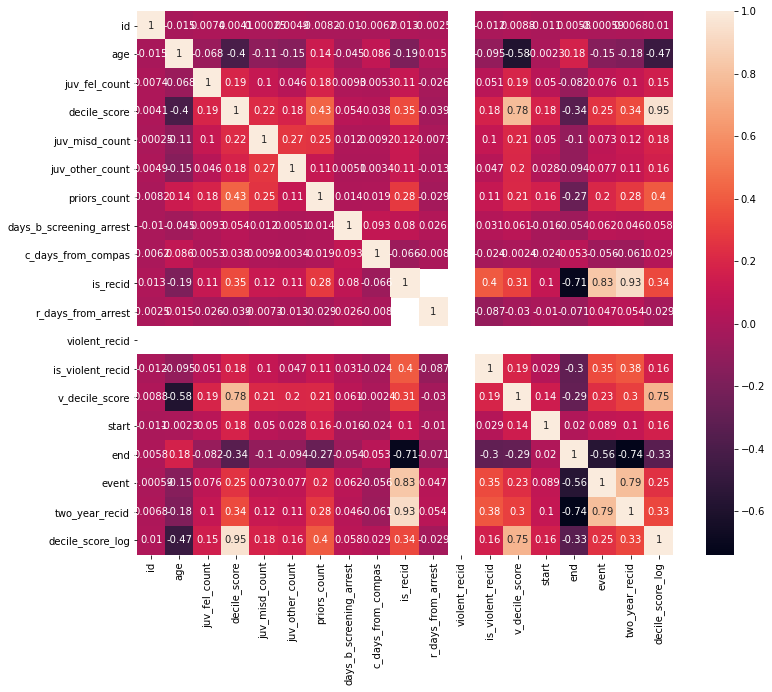

In [84]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True);

(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

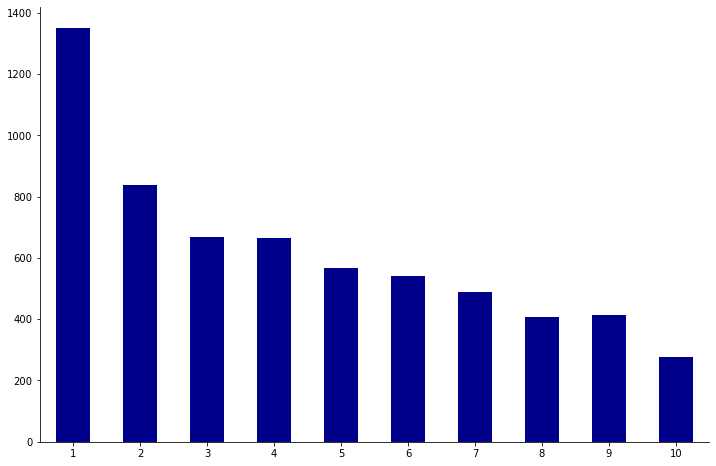

In [5]:
def create_groupcount_barplot(df, group_col, figsize, **kwargs):
    "call df.groupby(group_col), then count number of records and plot"
    counts = df.groupby(group_col)["name"].count().sort_index()

    fig, ax = plt.subplots(figsize=figsize)
    counts.plot(kind="bar", **kwargs)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_xlabel("")
    ax.set_ylabel("")

    return fig, ax

create_groupcount_barplot(df, "decile_score", (12, 8), color="DarkBlue", rot=0)

# We can already observe that that our target variable is normally distributed. Therefore, we will proceed with the log of decile score.

In [6]:
df['decile_score_log'] = np.log(df.decile_score)

In [7]:
print(df.decile_score.skew())
print(df.decile_score_log.skew())

0.44499634284609496
-0.34657083633759855


* If skewness is between -0.5 and 0.5, the distribution is approximately symmetric. We have around -0.35.

In [8]:
features = pd.concat([df.age,
                    pd.get_dummies(df.sex, prefix='sex',drop_first=True),
                    pd.get_dummies(df.race, prefix='race',drop_first=True),  
                    pd.get_dummies(df.c_charge_degree, prefix='degree',drop_first=True), # felony or misdemeanor charge ('f' or 'm')
                    df.priors_count,
                    df.juv_fel_count,
                    df.juv_misd_count,
                    df.juv_other_count,
                    df.two_year_recid],
                    axis=1)

target= df.decile_score_log

In [9]:
minmax_scaler = MinMaxScaler()
features_scaled = minmax_scaler.fit_transform(features)

In [10]:
df_scaled = pd.DataFrame(features_scaled, columns=features.columns)
df_scaled['decile_score'] = np.log(df.decile_score)
df_scaled.head()

,age,sex_Male,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,degree_M,priors_count,juv_fel_count,juv_misd_count,juv_other_count,two_year_recid,decile_score
0,0.649351,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
1,0.194805,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.0,1.098612
2,0.064935,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.108108,0.0,0.000000,0.058824,1.0,1.386294
3,0.051948,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027027,0.0,0.076923,0.000000,0.0,2.079442
4,0.311688,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.054054,0.0,0.000000,0.000000,0.0,0.000000


# Linear Regression

In [11]:
features_scaled = df_scaled[["age",
                    "sex_Male",
                    "race_Asian",  
                    "race_Caucasian",
                    "race_Hispanic",
                    "race_Native American",
                    "race_Other",
                    "degree_M",
                    "priors_count",
                    "juv_fel_count",
                    "juv_misd_count",
                    "juv_other_count",
                    "two_year_recid"]]

target_log= df_scaled.decile_score

In [12]:
x = features_scaled.values
y=target_log.values
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.33)

In [13]:
linearreg = LinearRegression()
linearreg.fit(X_train,y_train)
y_pred = linearreg.predict(X_test)

In [14]:
r2_score(y_test, y_pred)

0.46901351662745816

In [15]:
mean_squared_error(y_test, y_pred)

0.3333835491855263

# Polynomial Feautures

* The best degree of polynomial should be the degree that generates the lowest RMSE in cross validation set. 

In [16]:
features_new = df_scaled[["age",
                    "sex_Male",
                    "race_Asian",  
                    "race_Caucasian",
                    "race_Hispanic",
                    "race_Native American",
                    "race_Other",
                    "degree_M",
                    "priors_count",
                    "juv_fel_count",
                    "juv_misd_count",
                    "juv_other_count",
                    "two_year_recid"]]

target_new= df_scaled.decile_score

In [17]:
x_new = features_scaled.values
y_new=target_log.values
X_train, X_test, y_train, y_test = train_test_split(x_new,y_new, test_size=0.33)

Best degree 3 with RMSE 0.5826517461175078


Text(0, 0.5, 'RMSE')

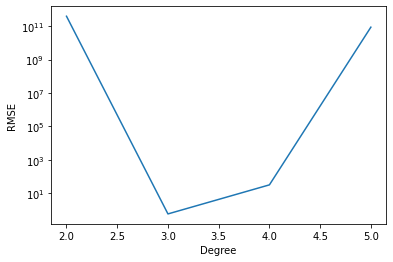

In [19]:
rmses = []
degrees = np.arange(2, 6)
min_rmse, min_deg = 1e10, 0

for deg in degrees:

    # Train features
    poly_features = PolynomialFeatures(degree=deg, include_bias=False)
    x_poly_train = poly_features.fit_transform(X_train)

    # Linear regression
    poly_reg = LinearRegression()
    poly_reg.fit(x_poly_train, y_train)

    # Compare with test data
    x_poly_test = poly_features.fit_transform(X_test)
    poly_predict = poly_reg.predict(x_poly_test)
    poly_mse = mean_squared_error(y_test, poly_predict)
    poly_rmse = np.sqrt(poly_mse)
    rmses.append(poly_rmse)
    
    # Cross-validation of degree
    if min_rmse > poly_rmse:
        min_rmse = poly_rmse
        min_deg = deg

# Plot and present results
print('Best degree {} with RMSE {}'.format(min_deg, min_rmse))
        
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(degrees, rmses)
ax.set_yscale('log')
ax.set_xlabel('Degree')
ax.set_ylabel('RMSE')

In [20]:
degree=3
polyreg_scaled=make_pipeline(PolynomialFeatures(degree),LinearRegression())
polyreg_scaled.fit(X_train,y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('linearregression', LinearRegression())])

In [21]:
y_pred = linearreg.predict(X_test)
r2_score(y_test, y_pred)

0.47397756290816195

In [22]:
mean_squared_error(y_test, y_pred)

0.31507208382746804

# Lasso Regression

In [ ]:
features_new = df_scaled[["age",
                    "sex_Male",
                    "race_Asian",  
                    "race_Caucasian",
                    "race_Hispanic",
                    "race_Native American",
                    "race_Other",
                    "degree_M",
                    "priors_count",
                    "juv_fel_count",
                    "juv_misd_count",
                    "juv_other_count",
                    "two_year_recid"]]

target_new= df_scaled["decile_score"]

In [37]:
x = features_new
y=target_log.values
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.33)


In [38]:
#optimal parameter

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha':np.arange(0.1,1,0.05)}

lasso = Lasso()

lasso_cv = GridSearchCV(lasso, param_grid, cv = 5)

lasso_cv.fit(X_train, y_train)
print(lasso_cv.best_params_)

print('Training Score:', lasso_cv.score(X_train, y_train))
print('Test Score:', lasso_cv.score(X_test, y_test))

{'alpha': 0.1}
Training Score: 0.03759031039278282
Test Score: 0.037587648264930995


In [39]:
lasso = Lasso(alpha=0.1) #, normalize=True)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)
#Returns the coefficient of determination R^2 of the prediction.
lasso.score(X_test, y_test)
r2_score(y_test, lasso_pred)

0.037587648264930995

In [52]:
mean_squared_error(y_test, lasso_pred)

0.5872441027416103

# Ridge Regression

In [62]:
features_new = df_scaled[["age",
                    "sex_Male",
                    "race_Asian",  
                    "race_Caucasian",
                    "race_Hispanic",
                    "race_Native American",
                    "race_Other",
                    "degree_M",
                    "priors_count",
                    "juv_fel_count",
                    "juv_misd_count",
                    "juv_other_count",
                    "two_year_recid"]]

target_new= df_scaled.decile_score

In [63]:
X = features_scaled.values
y=target_new.values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33)

In [64]:
model = Ridge(alpha=1.0)
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean MAE: 0.461 (0.012)


In [68]:
ridge2 = Ridge(alpha=0.1, normalize=False)
ridge2.fit(X_train, y_train)
ridge2_pred = ridge2.predict(X_test)

In [71]:
r2_score(y_test, ridge2_pred)

0.4748987135898187

In [72]:
mean_squared_error(y_test, ridge2_pred)

0.3249262527028318

In [67]:
model = Ridge()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = arange(0, 1, 0.01)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X, y)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: -0.461
Config: {'alpha': 0.0}


* α = 0: The objective becomes same as simple linear regression.

# Elastic Net

In [77]:
features_new = df_scaled[["age",
                    "sex_Male",
                    "race_Asian",  
                    "race_Caucasian",
                    "race_Hispanic",
                    "race_Native American",
                    "race_Other",
                    "degree_M",
                    "priors_count",
                    "juv_fel_count",
                    "juv_misd_count",
                    "juv_other_count",
                    "two_year_recid"]]

target_new= df_scaled.decile_score

In [78]:
X = features_scaled.values
y=target_new.values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33)

In [79]:
model = ElasticNet(alpha=1.0, l1_ratio=0.5)
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean MAE: 0.681 (0.013)


In [81]:
ElasticNet = ElasticNet(alpha=0.1, normalize=False)
ElasticNet.fit(X_train, y_train)
ElasticNet_pred = ElasticNet.predict(X_test)

In [82]:
r2_score(y_test, ElasticNet_pred)

0.09264678348588506

In [83]:
mean_squared_error(y_test, ElasticNet_pred)

0.5453283613153656

In [80]:
model = ElasticNet()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid['l1_ratio'] = arange(0, 1, 0.01)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X, y)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: -0.461
Config: {'alpha': 0.0, 'l1_ratio': 0.0}


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:880: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 996.4816228757619, tolerance: 0.3811160076142395
  model = cd_fast.enet_coordinate_descent(


* α = 0: Again, the objective becomes same as simple linear regression.

# Logistic Regression

* scikit-learn’s LogisticRegression for classification problems only. 

In [93]:
features_new = df_scaled[["age",
                    "sex_Male",
                    "race_Asian",  
                    "race_Caucasian",
                    "race_Hispanic",
                    "race_Native American",
                    "race_Other",
                    "degree_M",
                    "priors_count",
                    "juv_fel_count",
                    "juv_misd_count",
                    "juv_other_count",
                    "two_year_recid"]]

target_new= df["decile_score"]

In [94]:
x = features_new
y=target_new.values
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(x,y, test_size=0.33)

In [95]:
logisticregression = LogisticRegression()
logisticregression.fit(X_train_log,y_train_log)
y_pred = logisticregression.predict(X_test_log)
print(y_pred)

[2 5 2 ... 3 1 1]


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [96]:
r2_score(y_test_log, y_pred)

0.11339535992821959

# Evaluating the final model.
* It is important to note that, before assessing or evaluating our model with evaluation metrics like R-squared, we must make use of residual plots. Residual plots expose a biased model than any other evaluation metric. If your residual plots look normal, go ahead, and evaluate your model with various metrics. Residual plots show the residual values on the y-axis and predicted values on the x-axis. If your model is biased you cannot trust the results. Residual plot showing the errors corresponding to the predicted values must be randomly distributed. However, if there are any signs of a systematic pattern, then your model is biased.
* One of the assumptions of a linear regression model is that the errors must be normally distributed. This means, make sure your residuals are distributed around zero for the entire range of predicted values. Thus, if the residuals are evenly scattered, then your model may perform well.